In [19]:
import torch 
import numpy as np
import matplotlib.pyplot as plt
from numpy.polynomial import legendre as leg
from scipy.integrate import quad
from scipy.linalg import eigh
from scipy.interpolate import UnivariateSpline

from training.model import create_model, create_optimizer
from training.metrics import compute_loss, compute_errors
from training.test_functions import generate_test_functions, FEM1D
from utils.problem import exact_u
from utils.visualization import plot_results, style_plot

In [20]:
N = 1000
nvals = 10
x = np.linspace(0, 1, N)

# FEM1D
stiff, mass = FEM1D(x)

# Vectores propios
vals, vecs = eigh(stiff[1:-1, 1:-1],
                  mass[1:-1, 1:-1],
                  subset_by_index=(0, nvals - 1))

vecs_comp = np.zeros((N, nvals))
vecs_comp[1:-1, :] = vecs

# Interpolación
x_eval = torch.linspace(0, 1, N).detach().numpy()
spline = UnivariateSpline(x, vecs_comp[:, 2], s=0, k=1)
v_eval = spline(x_eval)
v_eval = v_eval.reshape(N, 1)

Loss at iteration 200: 0.038789317011833
Loss at iteration 400: 0.019628467038274
Loss at iteration 600: 0.010680255480111
Loss at iteration 800: 0.008232416585088
Loss at iteration 1000: 0.007694229483604


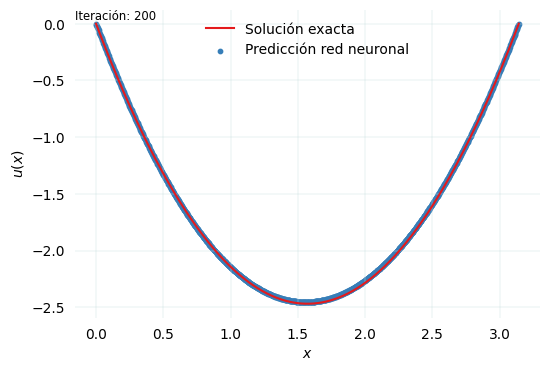

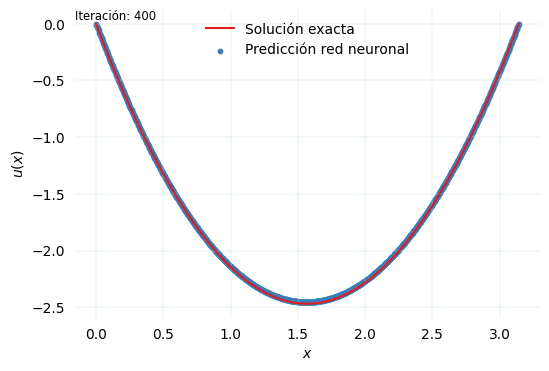

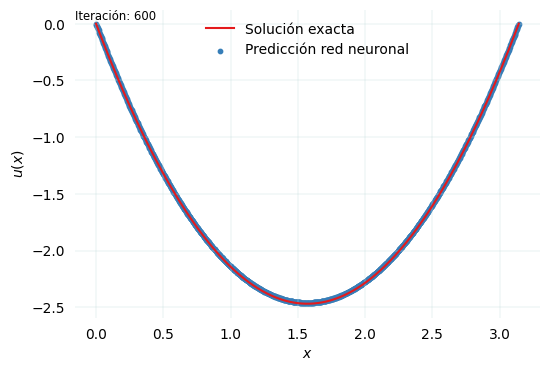

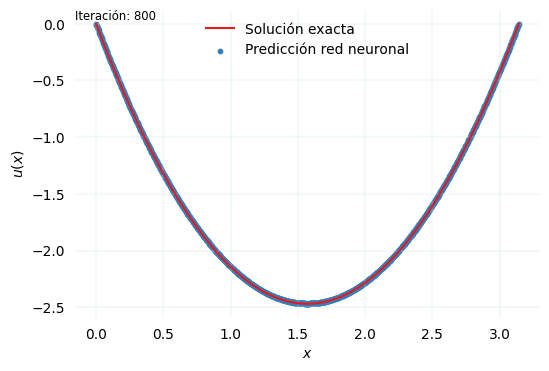

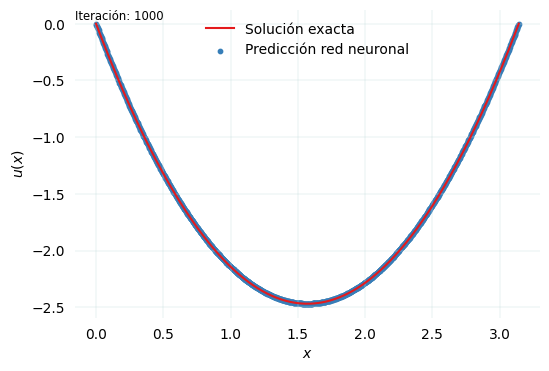

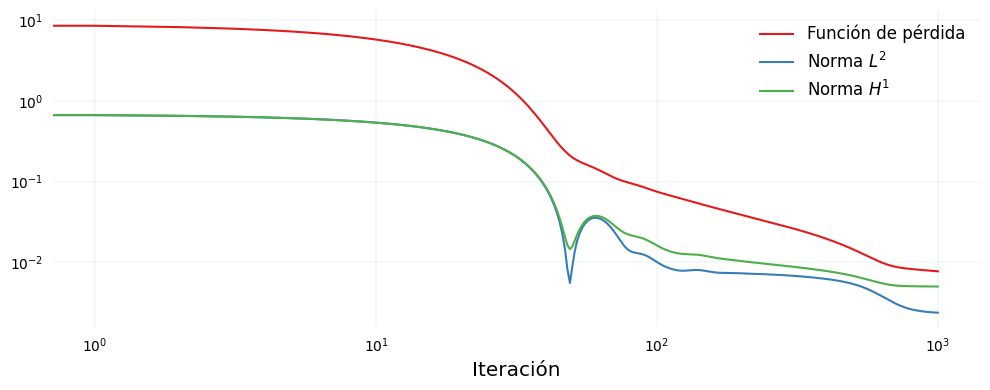

In [21]:
N_modes = 20
n_pts = 1000
iterations = 1000
torch.manual_seed(123)
model = create_model(model_name="FFNN")    
optimizer = create_optimizer(model)
losses = []
L2_relative_errors = []    
h1_norms = []      
n = torch.linspace(1, N_modes, N_modes)     
for i in range(iterations):        
    x = torch.linspace(0, np.pi, n_pts)        
    
    # Funciones de prueba
    v_test, v_dv = generate_test_functions(n_pts, vecs_comp)
    x = x.requires_grad_(True).view(n_pts, 1)   
    v = v_test
    dvs = v_dv
    
    optimizer.zero_grad()
    loss = compute_loss(model, x, v, dvs)        
    loss.backward(retain_graph=True)
    optimizer.step()                   
    losses.append(loss.item())
    L2_error, H1_norm = compute_errors(model, x, exact_u)
    L2_relative_errors.append(L2_error)  
    h1_norms.append(H1_norm)
    if (i+1) % 200 == 0:
        print(f"Loss at iteration {i+1}: {loss.item():.15f}")  
           
        x_test = torch.linspace(0, np.pi, n_pts).view(n_pts, 1)
        y_test = model(x_test).detach().numpy()    
        y_real = exact_u(x_test).detach().numpy() 
        style_plot(x_test, y_real, x_data=None, y_data=None, yh=y_test, i=i)   
        plt.savefig(f'plots/vpinn_{i+1}.pdf', dpi=300, bbox_inches='tight')    
plot_results(losses, L2_relative_errors, h1_norms)

In [17]:
import pandas as pd

# Convertir los tensores a numpy arrays
x_physics = x = torch.linspace(0, np.pi, n_pts).view(n_pts, 1)
y_test_np = exact_u(x_physics).detach().numpy()
y_real_np = model(x_physics).detach().numpy()

# Crear un DataFrame
df = pd.DataFrame({
    'x_test': x_physics.flatten(),
    'model_output': y_test_np.flatten(),
    'real_output': y_real_np.flatten()
})
df.to_csv("model_vs_real_output.csv", index=False)

**Función de pérdida, norma L2 y norma H1**

In [18]:
import pandas as pd
new_df = pd.DataFrame({"loss": losses, "L2_error": L2_relative_errors, "H1_norm": h1_norms})
new_df.head()
new_df.to_csv("loss_and_error.csv", index=False)

In [22]:
losses[-1], h1_norms[-1], L2_relative_errors[-1]

(0.007694229483604431, 0.004979727789759636, 0.002358692465350032)

#### **Errores relativos**


In [5]:
x_physics = torch.FloatTensor(n_pts,1).uniform_(0, np.pi).requires_grad_(True)

exact_function = exact_u(x_physics)
predicted_function = model(x_physics).detach()
error_between_arrays = exact_function - predicted_function

**MSE**

In [6]:
# Error relativo
output_error = torch.mean((error_between_arrays)**2)
output_error /= torch.mean(exact_function**2)
print(f"Output error: {output_error.item():.8f}")

Output error: 0.00041953


**Max**

In [7]:
max_error = torch.max(torch.abs(error_between_arrays))
max_error /= torch.max(torch.abs(exact_function))
print(f"Max error: {max_error.item():.8f}")

Max error: 0.09182091


**Min**

In [8]:
min_error = torch.min(torch.abs(error_between_arrays))
min_error /= torch.max(torch.abs(exact_function))
print(f"Min error: {min_error.item():.8f}")

Min error: 0.00000189


**Avg**

In [9]:
avg_error = torch.mean(torch.abs(error_between_arrays))
avg_error /= torch.mean(torch.abs(exact_function))
print(f"Avg error: {avg_error.item():.8f}")

Avg error: 0.01605532


### **Optimización de hiperparámetros**

In [ ]:
import torch.nn as nn

class FCN(nn.Module):  
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
        super().__init__()
        activation = nn.Tanh
        self.fcs = nn.Sequential(*[
            nn.Linear(N_INPUT, N_HIDDEN),
            activation()])
        self.fch = nn.Sequential(*[
                    nn.Sequential(*[
                        nn.Linear(N_HIDDEN, N_HIDDEN),
                        activation()]) for _ in range(N_LAYERS-1)])
        self.fce = nn.Linear(N_HIDDEN, N_OUTPUT)

    def forward(self, x):
        a = x * (x - torch.pi)
        x = self.fcs(x)
        x = self.fch(x)
        x = self.fce(x)        
        output = torch.einsum('ij,ij->ij', a, x)
        return output

In [20]:
import optuna
import torch.optim as optim

def objective(trial):    
    lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)
    hidden_layers = trial.suggest_int('hidden_layers', 1, 12)
    hidden_units = trial.suggest_int('hidden_units', 4, 16)
    N_modes = trial.suggest_int('N_modes', 10, 50)  
    
    model = FCN(1, 1, hidden_units, hidden_layers)    
    optimizer = optim.Adam(model.parameters(), lr=lr)

    for i in range(iterations):        
        x = torch.linspace(0, np.pi, n_pts)        
        v_test = torch.zeros(n_pts, N_modes)
        v_dv = torch.zeros(n_pts, N_modes)
        for j in range(min(vecs_comp.shape[1], N_modes)):
            spline_mode = UnivariateSpline(x, vecs_comp[:, j], s=0, k=1)
            v_mode = spline_mode(x)  
            v_mode = v_mode.reshape(n_pts, 1)              
            v_test[:, j] = torch.tensor(v_mode).squeeze()
            v_dv[:, j] = torch.tensor(spline_mode.derivative()(x)).squeeze()            

        x = x.requires_grad_(True).view(n_pts, 1)   
        v = v_test
        dvs = v_dv
        optimizer.zero_grad()
        loss = compute_loss(model, x, v, dvs)        
        loss.backward(retain_graph=True)
        optimizer.step()                   

    L2_error, H1_norm = compute_errors(model, x, exact_u)
    validation_loss =  H1_norm

    return validation_loss

# Crea un estudio y optimiza el objetivo
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

# Obtén los mejores hiperparámetros
best_params = study.best_params
print(f"Los mejores hiperparámetros son: {best_params}")

[I 2024-05-03 22:13:45,302] A new study created in memory with name: no-name-f5a774f5-000a-41b7-9f11-d4ad8bca6616
C:\Users\Juan Pablo\AppData\Local\Temp\ipykernel_324912\3587592590.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)
[I 2024-05-03 22:13:49,746] Trial 0 finished with value: 0.006585071794688702 and parameters: {'lr': 0.001200880854983322, 'hidden_layers': 8, 'hidden_units': 16, 'N_modes': 35}. Best is trial 0 with value: 0.006585071794688702.
[I 2024-05-03 22:13:53,720] Trial 1 finished with value: 0.006974219344556332 and parameters: {'lr': 0.023464356095168958, 'hidden_layers': 5, 'hidden_units': 10, 'N_modes': 11}. Best is trial 0 with value: 0.006585071794688702.
[I 2024-05-03 22:13:58,728] Trial 2 finished with value: 0.0013609963934868574 and parameters: {'lr'

Los mejores hiperparámetros son: {'lr': 0.051232389983748586, 'hidden_layers': 10, 'hidden_units': 13, 'N_modes': 38}
